#Projeto 1 aprendizagem de máquina - Reconhecimento de dígitos

Edgard Henrique Coelho Tavares da Silva - 20210027041

Gabriel Vieira Coutinho - 20210139075


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import linalg as LA
import random
from copy import deepcopy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

##Redução Dimensionalidade

In [ ]:
train_df = pd.read_csv('train.csv', sep=';')
test_df = pd.read_csv('test.csv', sep=';')

In [ ]:
def simetria_vertical_digito(matrixes):
    res = []
    for matrix in matrixes:
        soma = 0
        for i in range(0, 28): #28x28
            for j in range(0, 14): #metade
                soma += abs(matrix[(28 * i) + j] - matrix[(28 * i) + 27 - j])
        res.append(soma / 255.0)
    return np.array(res)


def simetria_horizontal_digito(matrixes):
    res = []
    for matrix in matrixes:
        soma = 0
        for i in range(0, 14):
            for j in range(0, 28):
                soma += abs(matrix[(28 * i) + j] - matrix[(28 * (27 - i)) + j])
        res.append(soma / 255.0)
    return np.array(res)


def intensidade_digito(matrixes):
    return np.array([sum(matrix) / 255.0 for matrix in matrixes])

In [ ]:
train_redu = pd.DataFrame()
train_redu['label'] = train_df.iloc[:, 0]
train_redu['intensidade'] = intensidade_digito(train_df.iloc[:, 1:].to_numpy())
train_redu['simetria'] = simetria_vertical_digito(train_df.iloc[:, 1:].to_numpy()) + simetria_horizontal_digito(train_df.iloc[:, 1:].to_numpy())
train_redu.to_csv('train_redu.csv', index=False)

test_redu = pd.DataFrame()
test_redu['label'] = test_df.iloc[:, 0]
test_redu['intensidade'] = intensidade_digito(test_df.iloc[:, 1:].to_numpy())
test_redu['simetria'] = simetria_vertical_digito(test_df.iloc[:, 1:].to_numpy()) + simetria_horizontal_digito(test_df.iloc[:, 1:].to_numpy())
test_redu.to_csv('test_redu.csv', index=False)

In [ ]:
train_redu

,label,intensidade,simetria
0,0,145.435294,148.572549
1,0,118.576471,137.113725
2,0,127.600000,134.047059
3,0,138.047059,151.003922
4,0,146.215686,122.501961
...,...,...,...
2181,5,105.686275,133.890196
2182,5,113.050980,116.698039
2183,5,110.725490,133.019608
2184,5,99.305882,132.133333


In [ ]:
test_redu

,label,intensidade,simetria
0,0,147.933333,130.470588
1,0,131.054902,122.721569
2,0,134.890196,151.725490
3,0,139.976471,133.921569
4,0,129.580392,130.274510
...,...,...,...
1110,5,96.121569,139.521569
1111,5,98.439216,130.729412
1112,5,95.141176,122.227451
1113,5,106.882353,128.007843


##Classificação dos dígitos 1 x 5

In [ ]:
train_redu_df_filtered = train_redu[train_redu['label'].isin([1, 5])]
test_redu_df_filtered = test_redu[test_redu['label'].isin([1, 5])]

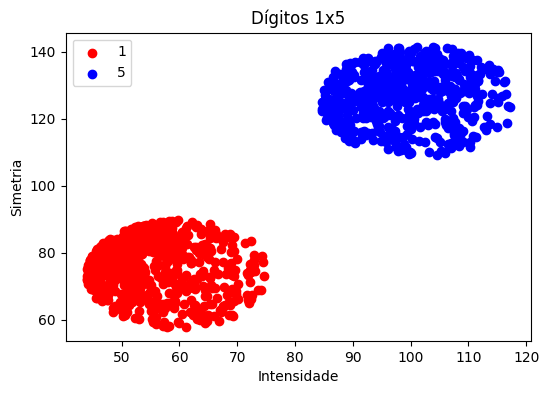

In [ ]:
train_1 = train_redu_df_filtered[train_redu_df_filtered['label'] == 1]
train_5 = train_redu_df_filtered[train_redu_df_filtered['label'] == 5]


plt.figure(figsize=(6, 4))

plt.scatter(train_1['intensidade'], train_1['simetria'], c='red', label='1')
plt.scatter(train_5['intensidade'], train_5['simetria'], c='blue', label='5')

plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Dígitos 1x5')
plt.legend()

plt.show()

In [ ]:
def unit_step_func(x):
    return np.where(x >= 0, 1, -1)

def classification_report(y_true, y_pred):
    # Inicializando a matriz de confusão
    tp = tn = fp = fn = 0

    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
        elif yt == -1 and yp == -1:
            tn += 1
        elif yt == -1 and yp == 1:
            fp += 1
        elif yt == 1 and yp == -1:
            fn += 1

    # Matriz de Confusão
    conf_matrix = np.array([[tn, fp], [fn, tp]])
    print('Matriz de Confusão:')
    print(conf_matrix)

    # Acurácia
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f'Acurácia: {accuracy:.4f}')

    # Precisão
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    print(f'Precisão: {precision:.4f}')

    # Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    print(f'Recall: {recall:.4f}')

    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f'F1 Score: {f1:.4f}')


def padronizar(train_data, test_data):
    # Calcular a média e o desvio padrão para cada característica do conjunto de treino
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)

    # Verifica se há desvios padrão zero e os substitui por 1 para evitar divisão por zero
    std_replaced = np.where(std == 0, 1, std)

    # Padronizar os dados de treinamento
    train_data_padronizado = (train_data - mean) / std_replaced

    # Padronizar os dados de teste usando as estatísticas do conjunto de treinamento
    test_data_padronizado = (test_data - mean) / std_replaced

    return train_data_padronizado, test_data_padronizado

In [ ]:
X_train = train_redu_df_filtered[['intensidade', 'simetria']].values
y_train = np.where(train_redu_df_filtered['label'] == 1, 1, -1)

X_test = test_redu_df_filtered[['intensidade', 'simetria']].values
y_test = np.where(test_redu_df_filtered['label'] == 1, 1, -1)

X_train, X_test = padronizar(X_train, X_test)

###Perceptron

In [ ]:
class Pocket_PLA:

    def __init__(self, learning_rate=0.01, n_iters=40000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.activation_func = unit_step_func
        self.weights = None
        self.bias = None
        self.best_weights = None
        self.best_bias = None
        self.best_error = np.inf

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        y_ = np.array(y)

        for _ in range(self.n_iters):
            errors = 0
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self.activation_func(linear_output)

                error = y_[idx] - y_predicted
                if error != 0:
                    errors += 1
                    update = self.lr * error
                    self.weights += update * x_i
                    self.bias += update

                    linear_output_all = np.dot(X, self.weights) + self.bias
                    y_predicted_all = self.activation_func(linear_output_all)
                    num_errors = np.sum(y_ != y_predicted_all)

                    if num_errors < self.best_error:
                        self.best_error = num_errors
                        self.best_weights = self.weights.copy()
                        self.best_bias = self.bias

            if errors == 0:
                print(f"Parou na iteração {_+1}")
                break

    def predict(self, X):
        linear_output = np.dot(X, self.best_weights) + self.best_bias
        y_predicted = self.activation_func(linear_output)
        return y_predicted

    def getW(self):
        return self.best_weights, self.best_bias


In [ ]:
Perceptron = Pocket_PLA(learning_rate=0.01, n_iters=100000)
Perceptron.fit(X_train, y_train)
Perceptron_predictions = Perceptron.predict(X_test)
Perceptron_accuracy = classification_report(y_test, Perceptron_predictions)

Perceptron_accuracy

Parou na iteração 3
Matriz de Confusão:
[[291   0]
 [  0 292]]
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1 Score: 1.0000


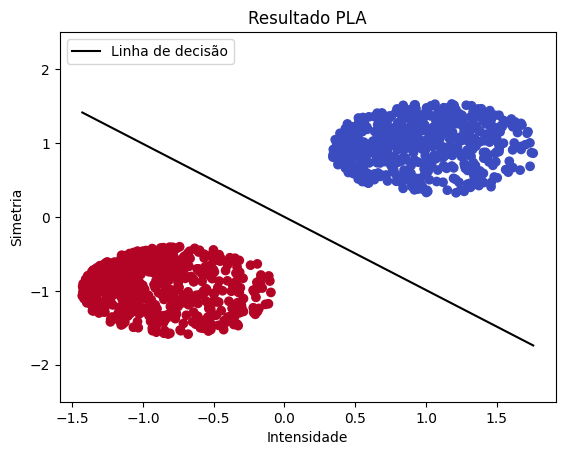

[-1.42780984  1.75728857]
[ 1.41288974 -1.73892554]


In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, cmap=plt.cm.coolwarm)


#w_1*x_1 + w_2*x_2 + b = 0, rearranjada para x_2 em termos de x_1:
x0_values = np.array([np.min(X_train[:, 0]), np.max(X_train[:, 0])])
x1_values = (-Perceptron.best_weights[0] * x0_values - Perceptron.best_bias) / Perceptron.best_weights[1]

plt.plot(x0_values, x1_values, "k", label='Linha de decisão')

plt.ylim(-2.5, 2.5)
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Resultado PLA')
plt.legend(loc='upper left')

plt.show()

###Regressão Linear

np.dot(X_b.T, X_b): Calcula o produto escalar da transposta de X_b por X_b mesmo. Isso resulta em uma matriz que é a base para calcular a inversa necessária na equação normal. Essa matriz representa, em termos de álgebra linear, uma forma de quantificar a relação entre todas as características.

np.dot(X_b.T, y): Representa o produto escalar da transposta de X_b pelo vetor de rótulos y. Isso alinha a orientação dos dados de entrada com os rótulos de saída, servindo como um vetor que sintetiza a relação alvo-característica nos dados.

inv(np.dot(X_b.T, X_b)): Calcula a inversa da matriz obtida no primeiro passo. A inversão dessa matriz é crucial para a solução da equação normal, pois permite "desfazer" o efeito do produto escalar, ajustando-se de forma que, quando aplicada ao vetor obtido no segundo passo, resulte nos pesos que minimizam a função de custo.

In [ ]:
class LinearRegressionClassifier:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        n_samples = X.shape[0]
        X_b = np.c_[np.ones((n_samples, 1)), X]  # Adiciona coluna de 1s para o viés
        h = np.dot(X_b.T, X_b)
        g = np.dot(X_b.T, y)
        self.w = np.dot(inv(h), g)  # Solução analítica

    def predict(self, X):
        n_samples = X.shape[0]
        X_b = np.c_[np.ones((n_samples, 1)), X]  # Adiciona coluna de 1s para o viés
        predictions = np.dot(X_b, self.w)
        return np.where(predictions >= 0, 1, -1)  # Classificação binária

    def getW(self):
        return self.w

In [ ]:
Linear_classifier = LinearRegressionClassifier()
Linear_classifier.fit(X_train, y_train)
Linear_pred = Linear_classifier.predict(X_test)
Linear_accuracy = classification_report(y_test, Linear_pred)

Linear_accuracy

Matriz de Confusão:
[[291   0]
 [  0 292]]
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1 Score: 1.0000


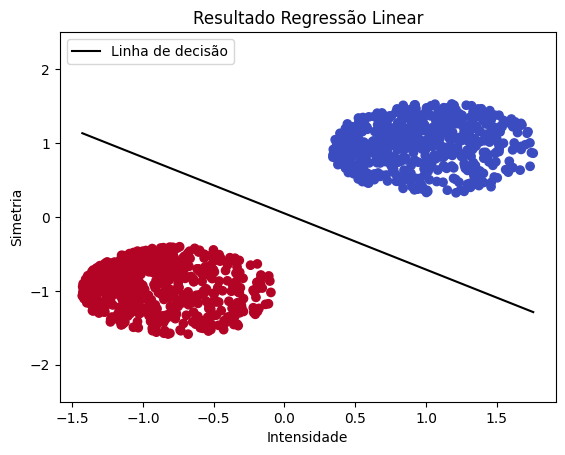

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)

# A equação da linha é w_0 + w_1*x_1 + w_2*x_2 = 0, rearranjada para x_2 em termos de x_1:
x1_values = np.array([np.min(X_train[:, 0]), np.max(X_train[:, 0])])
x2_values = -(Linear_classifier.w[0] + Linear_classifier.w[1] * x1_values) / Linear_classifier.w[2]

plt.plot(x1_values, x2_values, 'k', label='Linha de decisão')

plt.ylim(-2.5, 2.5)
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Resultado Regressão Linear')
plt.legend(loc='upper left')
plt.show()


###Regressão Logística

In [ ]:
class LogisticRegression:
    def __init__(self, eta=0.1, tmax=1000, batch_size=32):
        self.eta = eta
        self.tmax = tmax
        self.batch_size = batch_size

    def fit(self, _X, _y):
        X = np.concatenate((np.ones((len(_X), 1)), _X), axis=1)
        y = np.array(_y)

        d = X.shape[1] #d é definido como o número de características (incluindo o viés)
        N = X.shape[0] #N é o número de amostras.
        w = np.zeros(d, dtype=float) #vetor de pesos w com zeros.

        for i in range(self.tmax):
            vsoma = np.zeros(d, dtype=float) # acumular somas dos gradientes para atualização dos pesos.

            if self.batch_size < N:
                indices = random.sample(range(N), self.batch_size) #seleciona um subconjunto aleatório das amostras para calcular o gradiente.
                batchX = X[indices]
                batchY = y[indices]
            else:
                batchX = X
                batchY = y

            for xn, yn in zip(batchX, batchY):
                vsoma += (yn * xn) / (1 + np.exp(yn * (w.T @ xn)))

            gt = vsoma / self.batch_size

            # Verificação da norma do gradiente para a condição de parada
            if LA.norm(gt) < 1e-10:
                break

            w += self.eta * gt

        self.w = w

    def predict_prob(self, X):
        X = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        return [1 / (1 + np.exp(-(self.w.T @ x))) for x in X]

    def predict(self, X):
        probabilities = self.predict_prob(X)
        return np.array([1 if prob >= 0.5 else -1 for prob in probabilities])

    def getW(self):
        return self.w


In [ ]:
Logistic_classifier = LogisticRegression(eta=0.1, tmax=1000, batch_size=130)
Logistic_classifier.fit(X_train, y_train)
LR_predictions = Logistic_classifier.predict(X_test)
LR_accuracy = classification_report(y_test, LR_predictions)

LR_accuracy

Matriz de Confusão:
[[291   0]
 [  0 292]]
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1 Score: 1.0000


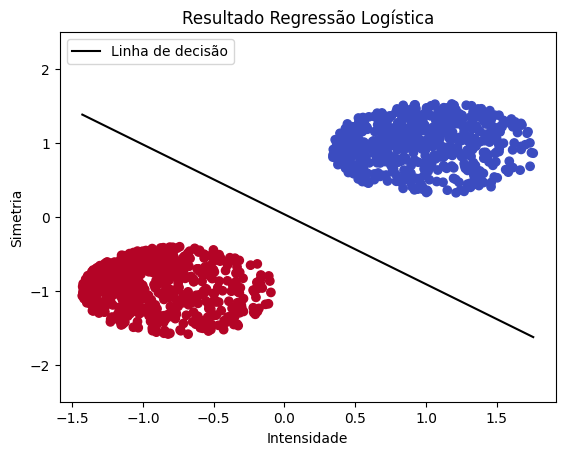

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, cmap=plt.cm.coolwarm)


x0_1 = np.amin(X_train[:, 0])
x0_2 = np.amax(X_train[:, 0])

w = Logistic_classifier.getW()
x1_1 = -(w[0] + w[1] * x0_1) / w[2]
x1_2 = -(w[0] + w[1] * x0_2) / w[2]

plt.plot([x0_1, x0_2], [x1_1, x1_2], "k", label='Linha de decisão')


plt.ylim(-2.5, 2.5)
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Resultado Regressão Logística')
plt.legend(loc='upper left')
plt.show()

##Classificador Completo

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predições')
    plt.ylabel('Verdadeiros')
    plt.show()

In [ ]:
# Preparar o conjunto de dados
X_train = train_redu[['intensidade', 'simetria']].values
y_train = train_redu['label'].values

X_test = test_redu[['intensidade', 'simetria']].values
y_test = test_redu['label'].values


X_train, X_test = padronizar(X_train, X_test)
digitos = [1,0,4,5]

In [ ]:
class classificacao_completa:

    def __init__(self, model=None, digitos=None):
        self.model = model
        self.digitos = digitos
        self.classifiers = []
        self.all_w = []

    def train(self, X_train, y_train):
        self.classifiers = []
        self.all_w = []
        for digit in self.digitos[:-1]:
            y_binary = np.where(y_train == digit, 1, -1)
            model_clone = deepcopy(self.model)  # Cria uma cópia do modelo
            model_clone.fit(X_train, y_binary)
            self.classifiers.append(model_clone)
            self.all_w.append(model_clone.getW())
            X_train = np.delete(X_train, np.where(y_train == digit), axis=0)
            y_train = np.delete(y_train, np.where(y_train == digit))

    def execute(self, X):
        final_predictions = np.full(X.shape[0], -1)  # Inicializa todas as predições com -1
        for classifier, digit in zip(self.classifiers, self.digitos[:-1]):
            current_prediction = classifier.predict(X)
            # Se o classificador atual prevê +1, atualize a predição
            final_predictions[(current_prediction == 1) & (final_predictions == -1)] = digit
        # Atribui o último dígito para qualquer previsão ainda marcada como -1
        final_predictions[(final_predictions == -1)] = self.digitos[-1]
        return final_predictions

    def get_weights(self):
        return self.all_w

###Perceptron

In [ ]:
model = Pocket_PLA()
onevsall = classificacao_completa(model, digitos)
onevsall.train(X_train, y_train)
predicoes = onevsall.execute(X_test)

Parou na iteração 2


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       218
           1       1.00      1.00      1.00       292
           4       0.94      0.91      0.93       314
           5       0.89      0.93      0.91       291

    accuracy                           0.95      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.95      0.95      0.95      1115



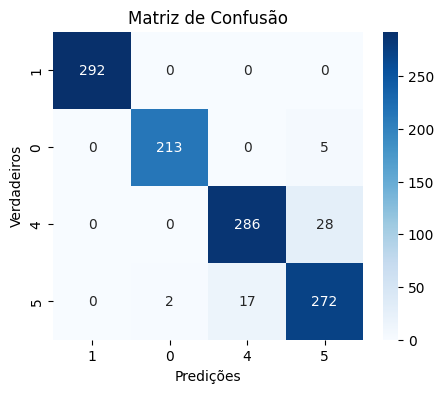

In [ ]:
report = metrics.classification_report(y_test, predicoes)
print(report)
classes = onevsall.digitos
plot_confusion_matrix(y_test, predicoes, classes)

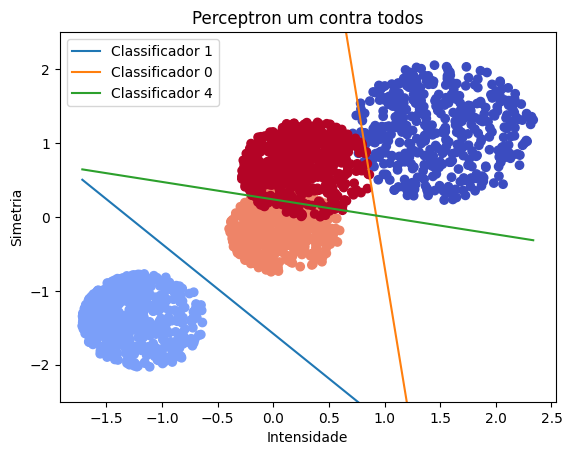

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)

for classifier, digit in zip(onevsall.classifiers, digitos[:-1]):
    weights, bias = classifier.getW()  # Extraia os pesos e o viés
    # A linha é definida pela equação: weights[0]*x + weights[1]*y + bias = 0
    # Para os valores x, calcule os correspondentes valores y
    x_values = np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]), num=100)
    y_values = -(bias + weights[0] * x_values) / weights[1]
    plt.plot(x_values, y_values, label=f'Classificador {digit}')

plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Perceptron um contra todos')
plt.legend()
plt.ylim(-2.5, 2.5)
plt.show()

###Regressão Linear

In [ ]:
model = LinearRegressionClassifier()
onevsall = classificacao_completa(model, digitos)
onevsall.train(X_train, y_train)
predicoes = onevsall.execute(X_test)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       218
           1       1.00      1.00      1.00       292
           4       0.93      0.97      0.95       314
           5       0.93      0.92      0.93       291

    accuracy                           0.96      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



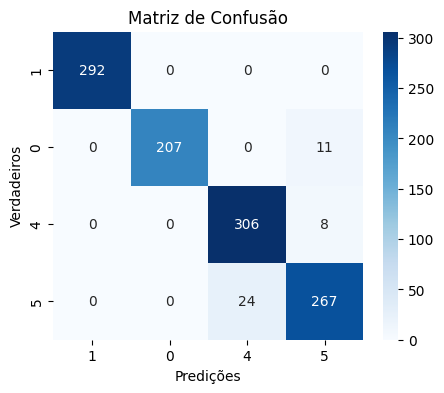

In [ ]:
report = metrics.classification_report(y_test, predicoes)
print(report)
classes = onevsall.digitos
plot_confusion_matrix(y_test, predicoes, classes)

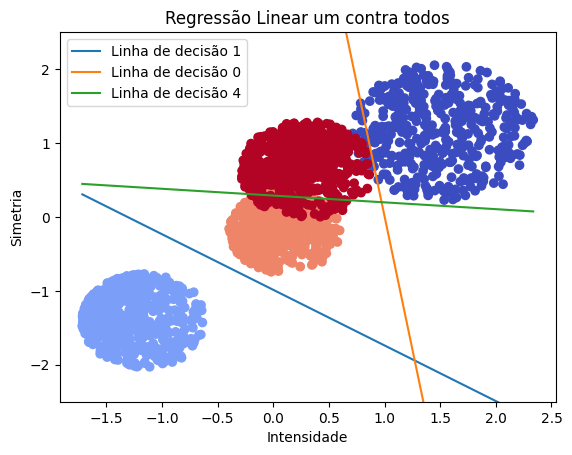

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, cmap=plt.cm.coolwarm)
for classifier, digit in zip(onevsall.classifiers, digitos[:-1]):
    w = classifier.getW()
    x_values = np.array([np.min(X_train[:, 0]), np.max(X_train[:, 0])])
    y_values = -(w[0] + w[1] * x_values) / w[2]
    plt.plot(x_values, y_values, label=f'Linha de decisão {digit}')

plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Regressão Linear um contra todos')
plt.ylim(-2.5, 2.5)

plt.legend()
plt.show()


###Regressão Logística

In [ ]:
model = LogisticRegression(eta=0.1, tmax=10000, batch_size=130)
onevsall = classificacao_completa(model, digitos)
onevsall.train(X_train, y_train)
predicoes = onevsall.execute(X_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       218
           1       1.00      1.00      1.00       292
           4       0.94      0.95      0.94       314
           5       0.94      0.93      0.93       291

    accuracy                           0.97      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.97      0.97      0.97      1115



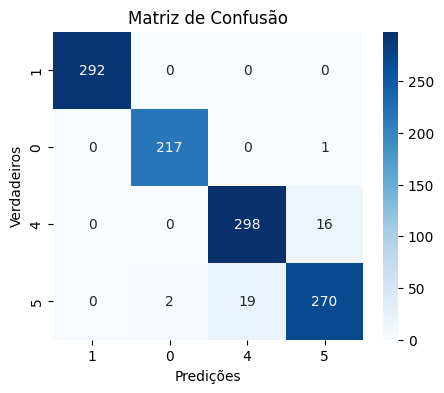

In [ ]:
report = metrics.classification_report(y_test, predicoes)
print(report)
classes = onevsall.digitos
plot_confusion_matrix(y_test, predicoes, classes)

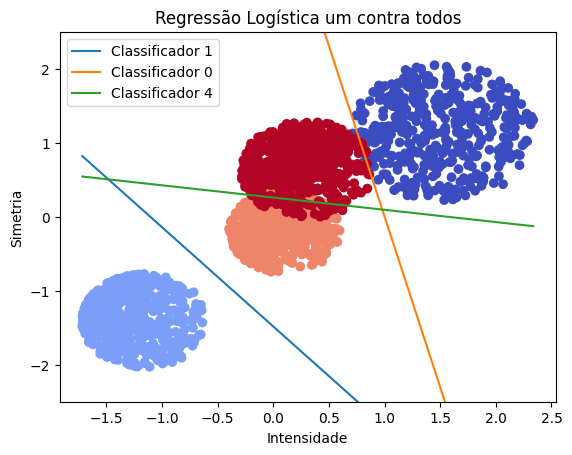

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)

for classifier, digit in zip(onevsall.classifiers, onevsall.digitos[:-1]):
    w = classifier.getW()
    # A fronteira de decisão é onde a soma ponderada é 0, ou seja, w0 + w1*x1 + w2*x2 = 0.
    # Resolvendo para x2 em termos de x1: x2 = -(w0 + w1*x1)/w2
    x_values = np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]), num=100)
    y_values = -(w[0] + w[1] * x_values) / w[2]
    plt.plot(x_values, y_values, label=f'Classificador {digit}')

plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Regressão Logística um contra todos')

plt.ylim(-2.5, 2.5)
plt.legend()
plt.show()